# Kiltisbotin kulutusdata

Kiltisbot on Fyysikkokillan kiltistoimikunnan ylläpitämä Telegramin bottirajapintaan pohjautuva multimedia ratkaisu, jonka tarkoitus on helpottaa kiltalaisten elämää. Kiltibotissa on tällä hetkellä integraatiot niin Fiirumille kuin Fyysikkokillan Googlekalenteriinkin. Kiltisbotin alkuperäinen ja tärkein käyttötarkoitus on kiltiksen herkkukaapin piikkimyynnin siirtäminen 2000-luvulle eli paperisesta piikkilistasta pilveen.

Kiltisbot otettiin käyttöön 13.4.2019 ja tätä juttua varten on käytetty dataa yhden vuoden ajalta 13.4.2019 - 12.4.2020. 

In [103]:
# Assumes that your ssh key is in the guild's server. Contact tech support if needed.
!scp root@104.248.244.199:/root/fk-kiltisbot/kiltis_PROD.db .

kiltis_PROD.db                                100%  144KB 532.3KB/s   00:00    


In [87]:
import datetime

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats

from scipy.stats import norm, normaltest

In [142]:
conn = sqlite3.connect("kiltis_PROD.db")

In [143]:
sql = """
SELECT *
FROM transactions
"""
data = pd.read_sql(sql, conn)

In [144]:
data["datetime"] = data.aika.astype("datetime64")
data["date"] = data.aika.apply(lambda x: x[:10]).astype("datetime64")
data["weekday"] = data.date.apply(lambda x: x.isocalendar()[2])
data["week"] = data.date.apply(lambda x: x.isocalendar()[1])
data["minute"] = data.aika.apply(lambda x: int(x.split(":")[1]))
data["hour"] = data.datetime.apply(lambda x: x.hour)

In [145]:
nostot = data[data.tuote == "NOSTO"]
panot = data[data.tuote == "PANO"]
ostot = data[(data.tuote != "NOSTO") & (data.tuote != "PANO")]

In [147]:
print("Tapahtumia yhteensä: {}".format(len(data)))
print("Panoja {} kappaletta.  Yhteensä {} euroa.".format(len(panot), panot.hinta.sum() / 100))
print("Nostoja {} kappaletta.   Yhteensä {} euroa.".format(len(nostot), nostot.hinta.sum() / 100))
print("Ostoja {} kappaletta. Yhteensä {:.2f} euroa.".format(len(ostot), ostot.hinta.sum() / 100))
print("Sähköisen kiltispiikin tase: {} euroa".format((panot.hinta.sum() - nostot.hinta.sum() - ostot.hinta.sum()) / 100))

Tapahtumia yhteensä: 2414
Panoja 194 kappaletta.  Yhteensä 1585.32 euroa.
Nostoja 32 kappaletta.   Yhteensä 110.15 euroa.
Ostoja 2188 kappaletta. Yhteensä 1316.40 euroa.
Sähköisen kiltispiikin tase: 158.77 euroa


## Tuotteiden kokonaiskysyntä

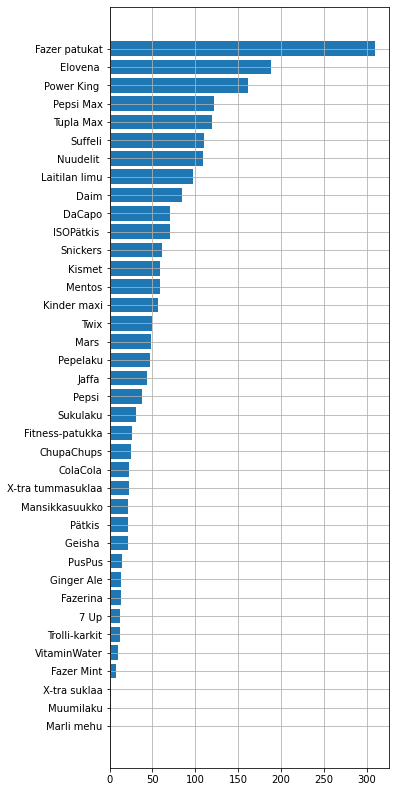

In [15]:
tuotteittainen = ostot.groupby("tuote").count().sort_values("id", ascending = True).reset_index()
plt.figure(1, (5, 14))
plt.barh(tuotteittainen.tuote, tuotteittainen.id)
plt.grid()
#plt.tight_layout()

## Päivittäiset kulutuksen vaihtelu vuoden sisällä

In [16]:
paivat = pd.DataFrame(columns=["date"], data=pd.date_range(start="2019-04-13", end="2020-04-12"))
paivittainen = paivat.merge(ostot, how="left", on="date").groupby("date").count().reset_index()

In [17]:
print("Keskiarvo: {:.2f}".format(paivittainen.tuote.mean()))
print("Keskihajonta: {:.2f}".format(paivittainen.tuote.std()))
print("Maksimi: {}".format(paivittainen.tuote.max()))
print("Minimi: {}".format(paivittainen.tuote.min()))

Keskiarvo: 5.98
Keskihajonta: 6.45
Maksimi: 32
Minimi: 0


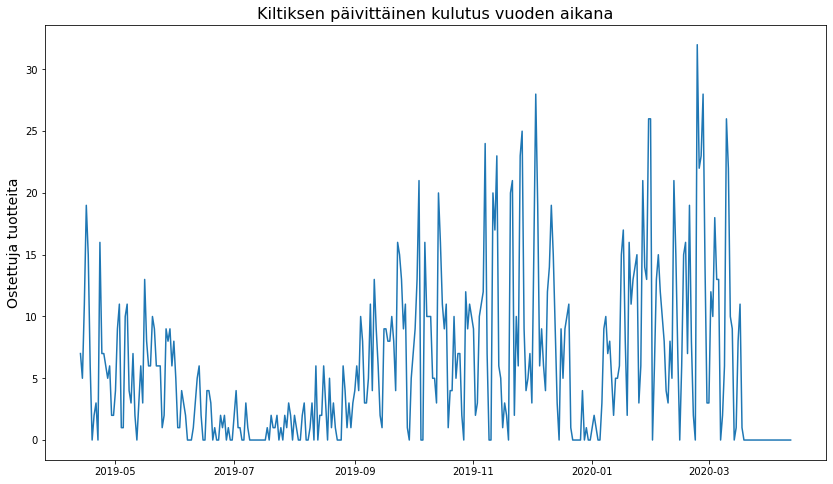

In [18]:
plt.figure(1, (14, 8))
plt.plot(paivittainen.date, paivittainen.tuote)
plt.title("Kiltiksen päivittäinen kulutus vuoden aikana", size=16)
plt.ylabel("Ostettuja tuotteita", size=14)
#plt.xticks(15 + np.arange(12) * 30, kuukaudet)
plt.show()

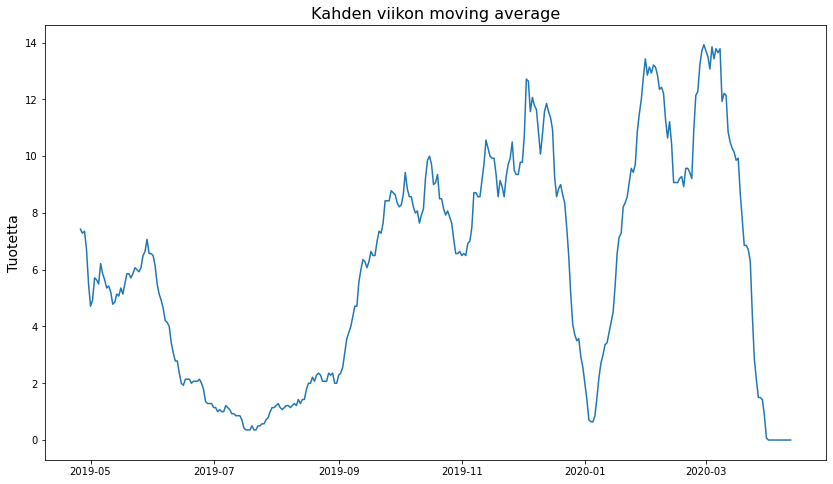

In [19]:
plt.figure(1, (14, 8))
plt.plot(paivittainen.date, paivittainen.tuote.rolling(14).mean())
plt.title("Kahden viikon moving average", size=16)
plt.ylabel("Tuotetta", size=14)
plt.show()

Maksimi 32 ostosta päivässä kirjattiin päivälle, jolloin järjestettiin myös killan vuoden 2020 vuosikokous.

## Kulutuksen vaihtelu viikon sisällä 

In [20]:
viikoittainen = ostot.groupby("weekday").count().reset_index()

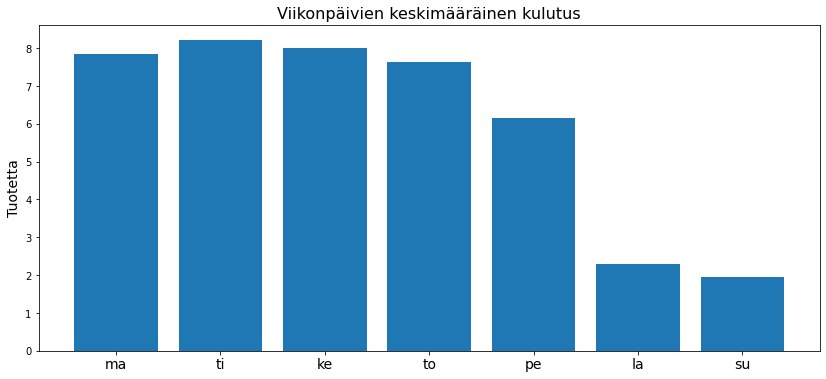

In [21]:
plt.figure(1, (14, 6))
plt.bar(np.arange(7), viikoittainen.tuote / 52)
plt.xticks(np.arange(7), ["ma", "ti", "ke", "to", "pe", "la", "su"], size=14)
plt.title("Viikonpäivien keskimääräinen kulutus", size=16)
plt.ylabel("Tuotetta", size=14)
plt.show()

## Viikoittaisen kulutuksen vaihtelu vuoden sisällä

In [22]:
weeks = pd.DataFrame(columns=["week"], data = 1 + (np.arange(0, 52) + 14) % 52)
viikot = weeks.merge(ostot, how="left", on="week").groupby("week").count().reset_index()

(0.0, 53.0)

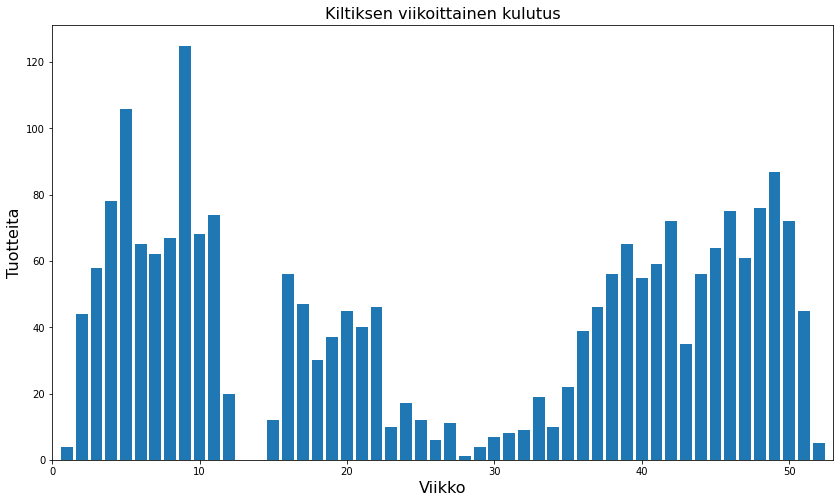

In [23]:
plt.figure(1, (14, 8))
plt.bar(viikot.week, viikot.tuote)
plt.title("Kiltiksen viikoittainen kulutus", size=16)
plt.ylabel("Tuotteita", size=16)
plt.xlabel("Viikko", size=16)
plt.xlim(0, 53)

## Minuutittainen tarkastelu

In [24]:
minuutittaiset = ostot.groupby("minute").count().reset_index()

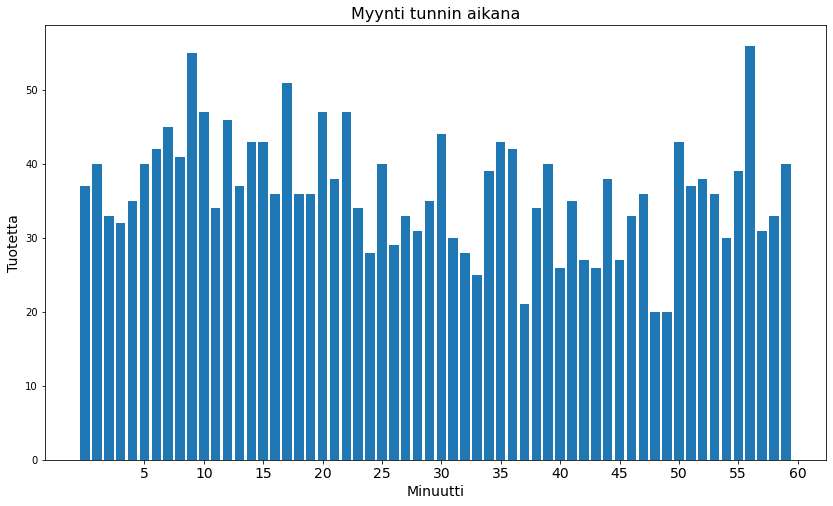

In [58]:
plt.figure(1, (14, 8))
plt.bar(minuutittaiset.minute, minuutittaiset.tuote)
plt.xticks(5 + np.arange(12) * 5, size=14)
plt.ylabel("Tuotetta", size=14)
plt.xlabel("Minuutti", size=14)
plt.title("Myynti tunnin aikana", size=16)
plt.show()

In [26]:
daily = ostot.hour * 60 + ostot.minute

In [27]:
x = np.linspace(0, 1440, 1000)
mu, std = norm.fit(daily)
p = norm.pdf(x, mu, std)

Text(0.5, 0, 'Minuutti')

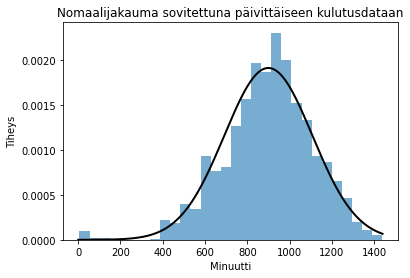

In [28]:
plt.hist(daily, density=True, bins=30, alpha=0.6)
plt.plot(x, p, linewidth=2, color="k")
plt.title("Nomaalijakauma sovitettuna päivittäiseen kulutusdataan")
plt.ylabel("Tiheys")
plt.xlabel("Minuutti")

In [29]:
tuotteet = list(set(data["tuote"]))
kayttajat = list(set(data["user"]))
m = np.zeros((len(tuotteet), len(kayttajat)))

In [52]:
def get_count(user, tuote):
    sql = """
    SELECT 
    COUNT(*)
    FROM transactions
    WHERE user = '{}'
    AND tuote = '{}'
    """.format(user, tuote)
    d = pd.read_sql(sql, conn)
    return d.iloc[0,0]

In [31]:
for i, t in enumerate(tuotteet):
    for j, k in enumerate(kayttajat):
        m[i, j] = get_count(k, t)

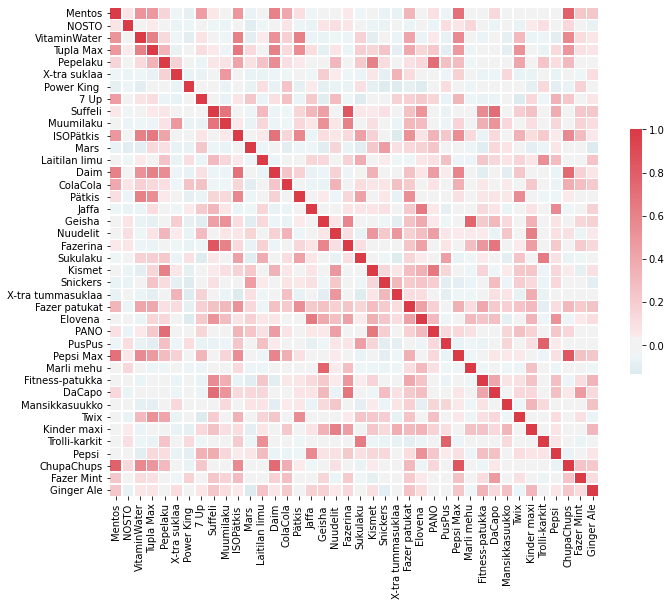

In [32]:
corr = np.corrcoef(m)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=tuotteet, yticklabels=tuotteet)

## Kiltispiikin viikonloppukäyttö

Kiltalaiset jakautuvat kahteen kastiin: niihin joilla on avain kiltahuoneelle ja niihin joilta tämä saavutettu etuus puuttuu. Tutkittaessa kuinka piikin viikonloppukäyttö suhtautuu sen kokonaiskäyttöön, tämä joukko käy erottuu.

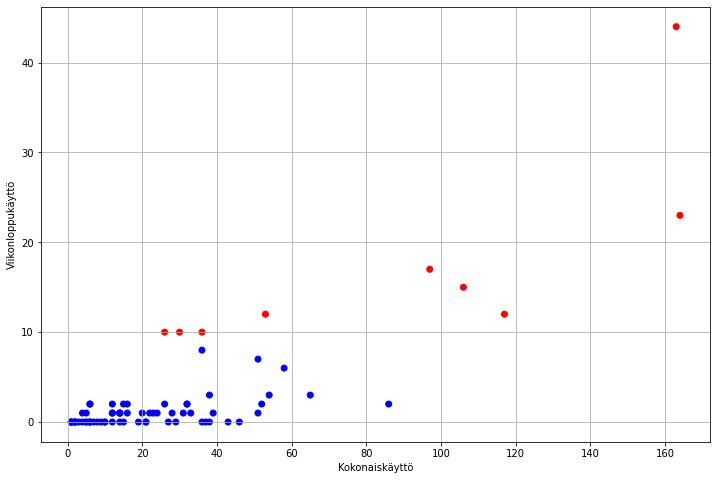

In [217]:
#TODO legend kilta eliitti vs kilta plebeijit
vkl_ostot = ostot[(ostot["weekday"] == 7) | (ostot["weekday"] == 6)]
vkl = vkl_ostot["user"].value_counts()
tot = ostot["user"].value_counts()

x = tot.values
y = [vkl[uid] if uid in vkl.keys() else 0 for uid in tot.keys()]
colors = ['r' if point >= 10 else 'b' for point in y]

plt.figure(1, (12, 8))
plt.scatter(x,y,c=colors,marker='o')
plt.grid()
plt.xlabel('Kokonaiskäyttö')
plt.ylabel('Viikonloppukäyttö')
plt.show()

## Eri tuotteiden mediaaniajat

Mediaanikiltalainen popsii muumilakun klo 11, juo Power Kingin klo 12, hörpää VitaminWaterin naamariin klo 15 ja skippaa päivällisen ja syö kiltahuoneella nuudelit ja fitness patukan hieman klo 17 jälkeen -- tämä kaikki tapahtuu tietenkin herkeämättömän kahvin ja teen ryystämisen ohella. Ohessa on esitetty mediaaniajat, jolloin osto on kirjattu bottiin.

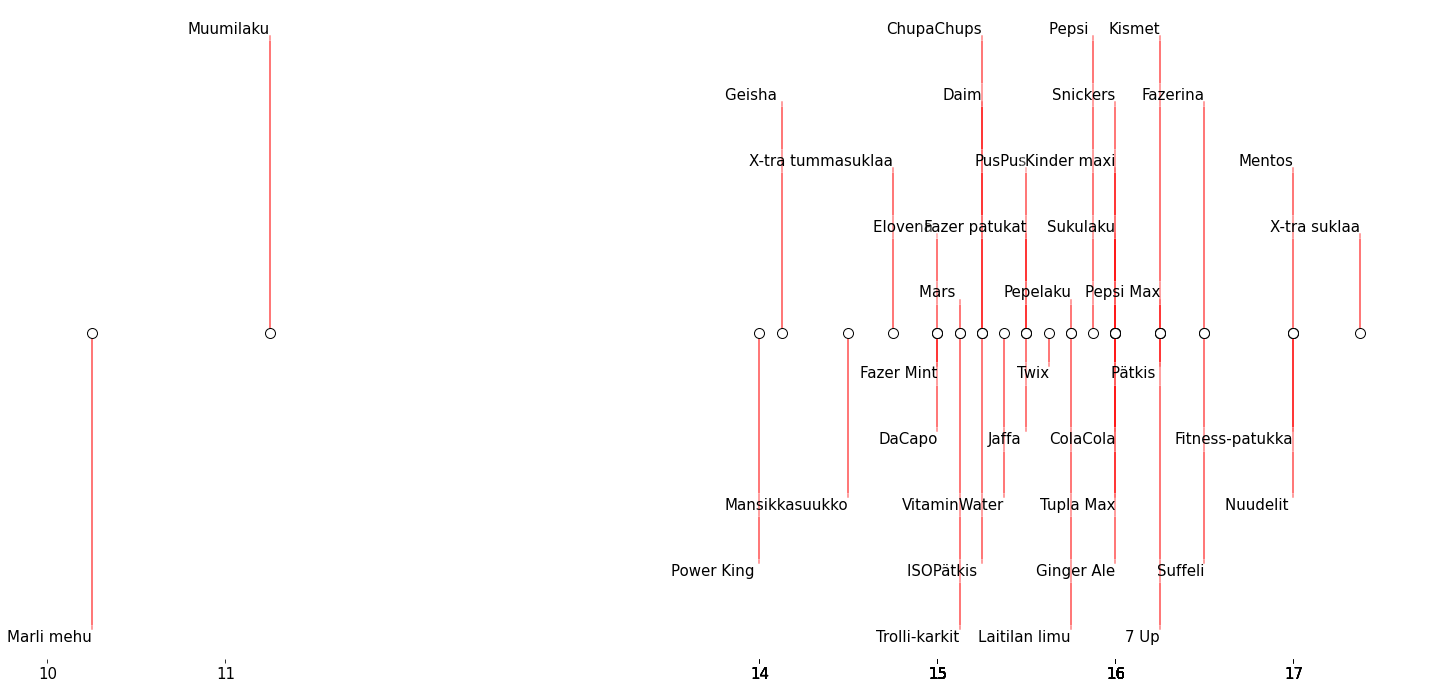

In [218]:
# 17.1.2020 server was changed which causes an offset of 2 hours
aikakorjatut_ostot = ostot.copy()
aikakorjatut_ostot.loc[ostot["date"] > np.datetime64('2020-01-17'), "hour"] += 2
aikakorjatut_ostot.loc[ostot["date"] > np.datetime64('2020-01-17'), "hour"] %= 24
aikakorjatut_ostot["quarter"] = 4 * aikakorjatut_ostot["hour"] + aikakorjatut_ostot["minute"] // 15

res = {}
products = ostot["tuote"].unique()
for p in products:
    d = aikakorjatut_ostot[aikakorjatut_ostot["tuote"] == p]
    res[p] = stats.median(d["quarter"])
res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])} # Sort by value

x = list(res.values())
y = res.keys()

# Plot timeline
levels = np.array([-9,9,-7,7,-5, 5, -3, 3, -1, 1])
fig, ax = plt.subplots(figsize=(25, 12))

# Create the base line
start = min(x)
stop = max(x)
ax.plot((x, x), (0, 0), 'k', alpha=.5)

# Iterate through median values annotating each one
for ii, (yy, xx) in enumerate(zip(y, x)):
    level = levels[ii % 10]
    vert = 'top' if level < 0 else 'bottom'

    ax.scatter(xx, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)
    # Plot a line up to the text
    ax.plot((xx, xx), (0, level), c='r', alpha=.7)
    # Give the text a faint background and align it properly
    ax.text(xx, level, yy,
            horizontalalignment='right', verticalalignment=vert, fontsize=15,
            backgroundcolor=(1., 1., 1., .3))
#ax.set(title="Mediaaniajat")
# Set the xticks formatting
# format xaxis with 3 month intervals
#ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=3))
#ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
#fig.autofmt_xdate()

# Remove components for a cleaner look
plt.setp((ax.get_yticklabels() + ax.get_yticklines() +
          list(ax.spines.values())), visible=False)

xtick_labels = [int(y // 4) for y in x]
xtick_pos = [4*y for y in xtick_labels]
plt.xticks(ticks=xtick_pos, labels=xtick_labels, fontsize=15,)
plt.show()

## Kiltispiikin käytön jakautuminen

Pieni joukko kiltalaisia käyttää bottia erityisen ahkerasti.

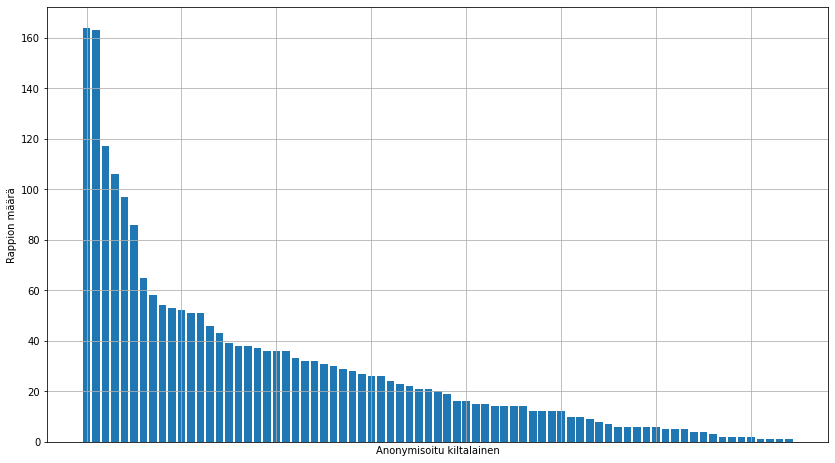

In [223]:
res = ostot["user"].value_counts()
x = range(len(res))

plt.figure(1, (14, 8))
plt.bar(x,res.values)
plt.ylabel("Rappion määrä");
plt.xlabel("Anonymisoitu kiltalainen");
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.grid()
#plt.axis('off') # remove all labels, add later with other software 
plt.show()

## Kiltahuoneen huoltovarmuuden turvaaminen

Ei tarvitse olla Supply Chain Analyst RELEXillä nähdäkseen seuraavista kuvaajista, että jos tavara on loppu, vaikuttaa se negatiivisesti tuotteen myyntiin.

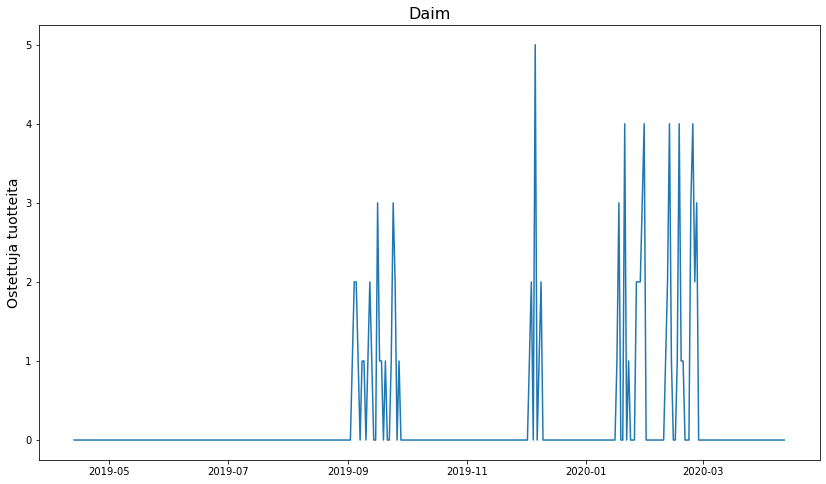

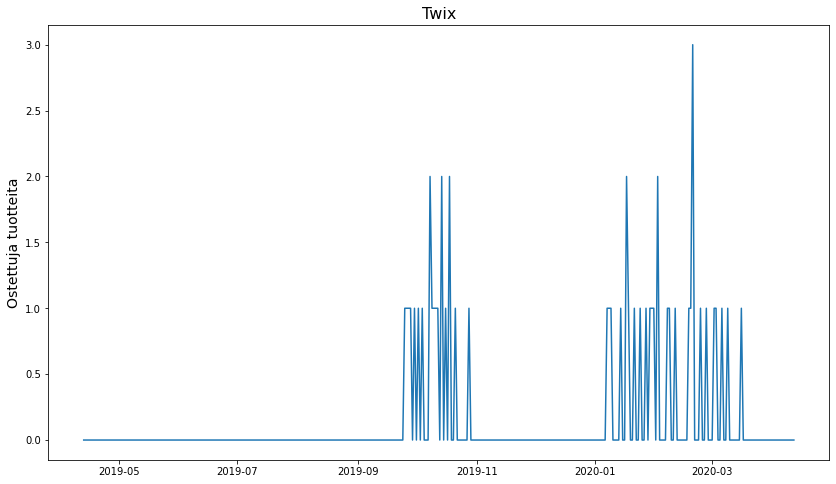

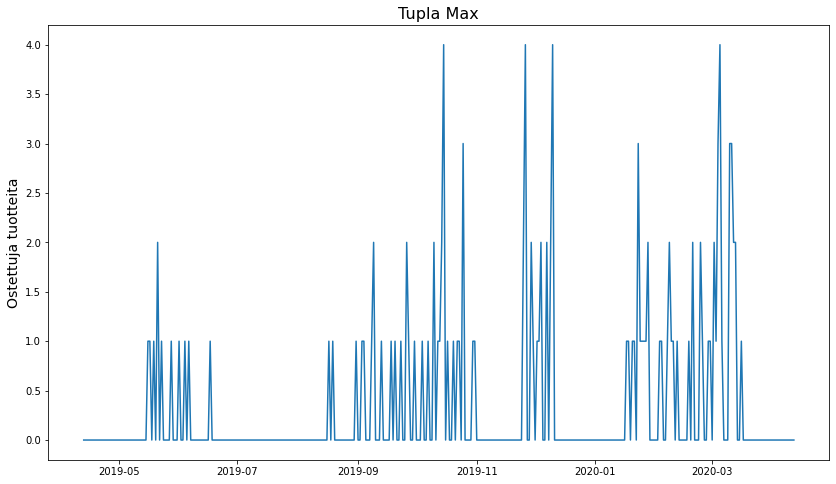

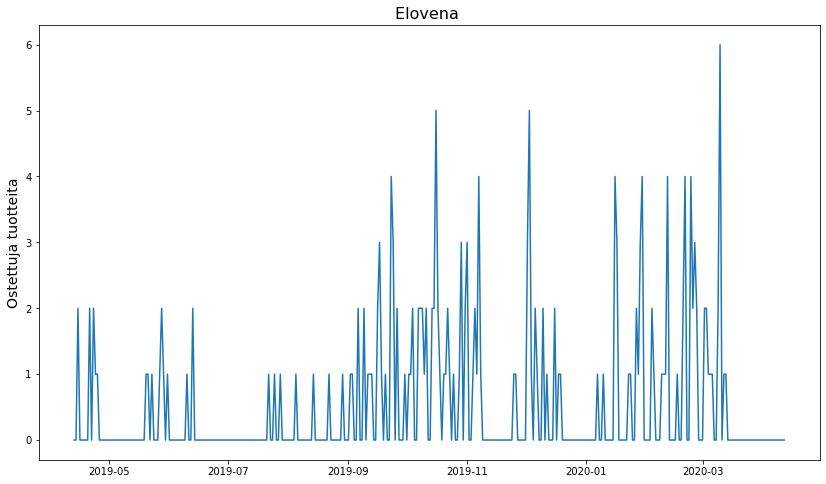

In [230]:
tuotteet = ["Daim", "Twix", "Tupla Max", "Elovena "]

for tuote in tuotteet:
    df = ostot[ostot.tuote == tuote]
    paivat = pd.DataFrame(columns=["date"], data=pd.date_range(start="2019-04-13", end="2020-04-12"))
    paivittainen = paivat.merge(df, how="left", on="date").groupby("date").count().reset_index()

    plt.figure(1, (14, 8))
    plt.plot(paivittainen.date, paivittainen.tuote)
    plt.title(tuote, size=16)
    plt.ylabel("Ostettuja tuotteita", size=14)
    plt.show()